# Caso de uso de Deep Learning en una empresa

## **Asistente Creativo de Marketing**

Trabajo realizado por:
* Leilani A.
* Lucia C.
* Maria Jose E.
* Maryam F.

# Setup

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google import genai
from google.genai import types
from PIL import Image, ImageDraw
from io import BytesIO
from google.colab import userdata
import requests
import re
import time

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# Funciones

## Generación de imagenes

In [ ]:
def resize_image(image):
    width, height = image.size
    new_width = width // 2
    new_height = height // 2
    return image.resize((new_width, new_height))

def text_to_image(prompt):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=prompt,
        config=types.GenerateContentConfig(
          response_modalities=['Text', 'Image']
        )
    )
    image = None
    for part in response.candidates[0].content.parts:
      if part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        if image is not None:
          image = resize_image(image)
    return image

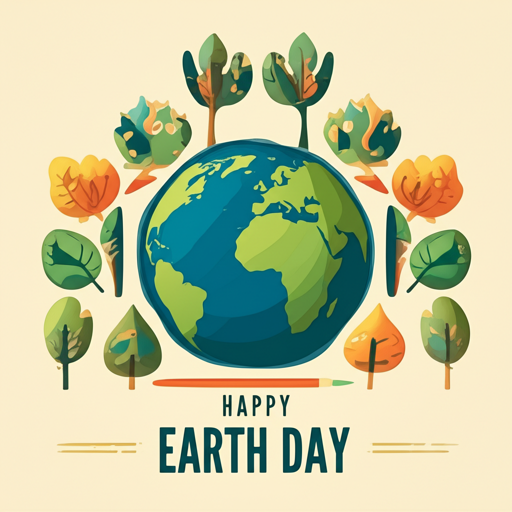

In [ ]:
prompt = 'I want to launch a campaign for earth day for students. Can you give me a poster to use'
img = text_to_image(prompt)
img

In [ ]:
def image_to_image(image, prompt, apply_resize=True):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=[image, prompt],
        config=types.GenerateContentConfig(
          response_modalities=['Text', 'Image']
        )
    )
    image = None
    for part in response.candidates[0].content.parts:
      if part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        if image is not None and apply_resize:
          image = resize_image(image)
    return image

## Generación de Texto

In [ ]:
def generate_text(user_prompt):
  response = client.models.generate_content(
      model="gemini-2.0-flash",
      contents=types.Content(
          role="user",
          parts=[
              types.Part.from_text(text=user_prompt),
          ],
      ),
  )
  return response.text

### Contenido de Marketing
* Slogan
* Plataformas de redes sociales + horarios mejores
* Hashtags

In [ ]:
def generate_marketing_content(product, prompt, target, campaign_goal, selected_platforms):
    preferred_text = f" Focus only on all of these platforms: {', '.join(selected_platforms)}." if selected_platforms else ""
    prompt = f"""You are a social media expert. Given the following information:
    - Product: {product}
    - Campaign goal: {campaign_goal}
    - Target audience: {target}
    {preferred_text}

    Provide the following:
    1. A catchy slogan.
    2. Ideal social media platforms for the campaign with best times to post.
      If one is not ideal, still mention the platform's name either way.
      If a platform is not ideal for this target and does not have a time range,
        always mention the platform and mention "Not Ideal", like this: Instagram: Not Ideal.
      If one of {preferred_text} one is not ideal, still mention the platform's name either way.
      Return per platform if possible.
      Be precise, no explanation needed.
      Return the answer as a bullet list like this:
        * Instagram: 6 PM - 8 PM
        * TikTok: 4 PM - 6 PM.
      No explanations. Just the list.
      Be precise, no explanation needed, just the social media platforms and time. No need to return the slogan and the target.
    3. Five relevant hashtags.

    Format your response as follows:

    ## Slogan:
    [Slogan]

    ## Social Media Platforms & Best Times to Post:
    * [Platform 1]: [Time range]
    * [Platform 2]: [Time range]
    ...

    ## Hashtags:
    #hashtag1 #hashtag2 #hashtag3 #hashtag4 #hashtag5
    """
    marketing_content = generate_text(prompt)
    time.sleep(1)  # Para evitar el error 503

    # Extrae el eslogan
    slogan_match = re.search(r"## Slogan:\n(.*?)\n", marketing_content, re.DOTALL)
    slogan = slogan_match.group(1).strip() if slogan_match else "No slogan found."

    # Extrae las plataformas y los horarios
    platforms_and_times_match = re.search(r"## Social Media Platforms & Best Times to Post:\n([\s\S]*?)\n##", marketing_content, re.MULTILINE)
    platforms_and_times = platforms_and_times_match.group(1).strip().split("\n") if platforms_and_times_match else []
    platforms_and_times = [platform_and_time.replace("* ", "").strip() for platform_and_time in platforms_and_times]

    # Extrae los hashtags
    hashtags_match = re.search(r"## Hashtags:\n(.*)", marketing_content, re.DOTALL)
    hashtags = hashtags_match.group(1).strip().split() if hashtags_match else []

    return slogan, platforms_and_times, hashtags

In [ ]:
test = generate_marketing_content('Earth Day', 'I want to launch a campaign for earth day for students. Can you give me a poster to use',
                           'Students', 'Brand awareness', ['LinkedIn', 'Instagram'])
print(test)

('Earth Day: Your Future Starts Now.', ['LinkedIn: 10 AM - 12 PM', 'Instagram: 4 PM - 7 PM'], ['#EarthDay', '#SustainableFuture', '#GoGreen', '#StudentAction', '#EcoFriendly'])


# Gradio

In [ ]:
import gradio as gr

input = [
    gr.Textbox(label="Producto"),
    gr.Textbox(lines=5, label="Prompt para Generación de Imagen"),
    gr.Dropdown(
        choices=["Students", "Parents", "Young Professionals", "Tech Enthusiasts", "Eco-Conscious Shoppers", "Gamers", "Retired", "Fitness Enthusiast"],
        label="Público al que quieres llegar"),
    gr.Dropdown(choices=["Increase sales", "Brand awareness", "Event promotion", "Community engagement", "Black Friday Sales"], label="Objetivo de la campaña"),
    gr.CheckboxGroup(choices=["Instagram", "Facebook", "LinkedIn", "TikTok", "YouTube", "X (formerly Twitter)"], label="¿Qué Redes Sociales Prefieres? (opcional)", value = []),
    gr.ColorPicker(label='Color Principal'),
    gr.ColorPicker(label='Color Secundario'),
    gr.File(label="Logo de la Empresa (opcional)", type="filepath")
    ]

output = [
    gr.Textbox(label = 'Slogan'),
    gr.Image(type="pil", label="Imagen Generada"),
    gr.Textbox(label = 'Plataformas ideales y horario recomendado'),
    gr.Textbox(label = 'Hashtags'),
    ]

def marketing(product, prompt, target, campaign_goal, selected_platforms, color_1st, color_2nd, logo_image):
    full_prompt = f"{prompt} Targeted at {target}. The goal is to {campaign_goal}. Use the following color scheme: {color_1st} and {color_2nd}."

    if logo_image:
      logo_img = Image.open(logo_image.name)
      logo_prompt = "Use this logo and place it naturally on signage, packaging, or a product."
      # Envia prompt de la imagen y logo a image_to_image
      imagen = image_to_image(logo_img, full_prompt + logo_prompt)
      time.sleep(1)

    else:
      imagen = text_to_image(full_prompt)
      time.sleep(1)

    slogan, platforms_and_times, hashtag = generate_marketing_content(product, prompt, target, campaign_goal, selected_platforms)

    # Extrae las plataformas sociales + horarios
    filtered_platforms_and_times = []
    for platform_and_time in platforms_and_times:
      platform_name = platform_and_time.split(":")[0].strip()  # Extraer el nombre de la plataforma
      if platform_name not in [p.split(":")[0].strip() for p in filtered_platforms_and_times]:
        filtered_platforms_and_times.append(platform_and_time)

    if not selected_platforms or not filtered_platforms_and_times:
        filtered_platforms_and_times = platforms_and_times

    return slogan, imagen, "\n".join(filtered_platforms_and_times), "\n".join(hashtag)


demo = gr.Interface(
    fn=marketing,
    title='Asistente Creativo de Marketing: Slogans, Imágenes y más a tu alcance',
    inputs=input,
    theme='allenai/gradio-theme',
    examples=[
        ['Gelato', 'I want to promote the new gelato flavor for summer. Create a colorful and fun promotional image for a new summer gelato flavor with gelato scoops, summer colors, and a sunny vibe.', 'Students', 'Brand awareness', [], '#FDDA0D', '#d97bd2', 'https://i0.wp.com/www.t4franquicias.com/wp-content/uploads/2018/05/Logo-T4.png'],
        ['Earth Day','I want to launch a campaign for earth day for students. Can you give me a poster to use', 'Students', 'Community engagement', ['LinkedIn'], '#87c979', '#3d95eb', None],
        ['New Gym Membership Deal', 'I want to promote the new gym membership deal. Give me an energetic and modern poster. The design should feel motivational and dynamic, ideal for social media promotion',
          'Fitness Enthusiast', 'Event promotion', ['Instagram', 'Facebook', 'LinkedIn', 'TikTok', 'YouTube', 'X (formerly Twitter)'] , '#f8df0a', '#f87d0a', None]],
    outputs=output)

demo.launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.2.0.json:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://458cd9470551ec9453.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
